<a href="https://colab.research.google.com/github/HWMV/AIFFEL_Quest1/blob/master/Machine_Learning/Airbnb_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Airbnb**

In [103]:
# 라이브러리 호출
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [104]:
# 데이터 셋 불러오기 (원본 데이터로 로컬/깃헙 작업)
url = 'https://raw.githubusercontent.com/HWMV/AIFFEL_Quest1/master/Machine_Learning/AB_NYC_2019.csv'
dataset = pd.read_csv(url)

# 가격 예측, price를 target으로 지정
x = dataset.drop('price', axis=1)
y = dataset['price']

# 성능 향상을 위한 target 값 로그 치환으로 정규화
y_log = np.log1p(y)

# 데이터 직접 분리
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y_log,
                                                    test_size=0.2,
                                                    random_state=2023)
# price
x_train['price'] = y_train
x_test['price'] = y_test

# **1. EDA**

In [105]:
# 데이터 크기 확인 (행열 확인)
x_train.shape, x_test.shape
# price 컬럼 추가 확인

((39116, 16), (9779, 16))

In [106]:
# 데이터 샘플 확인
display(x_train.head(2))

# price 컬럼 추가 해야 된다 데이터 분리 위 추가 코드 작성

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
34718,27528935,Private Room in Brooklyn,193502084,Linda,Brooklyn,Borough Park,40.63925,-74.00329,Private room,1,12,2019-03-23,1.16,8,0,3.713572
4046,2563611,Apartment 6,1163315,Craig,Manhattan,Harlem,40.80290,-73.95694,Private room,3,298,2019-06-27,4.67,1,42,4.653960


In [107]:
# Sample 확인
display(x_test.head(2))

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
42776,33216329,1 BR Suite in Midtown Manhattan,24831061,Hosteeva,Manhattan,Midtown,40.76453,-73.98035,Private room,1,0,NaN,NaN,8,0,5.525453
30338,23453013,Studio Near Times Square,2416454,Gen,Manhattan,Hell's Kitchen,40.76000,-73.98962,Entire home/apt,3,4,2018-07-28,0.26,1,0,5.170484


In [108]:
# Type
x_train.info()
# 16개 피처 type 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39116 entries, 34718 to 22041
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39116 non-null  int64  
 1   name                            39104 non-null  object 
 2   host_id                         39116 non-null  int64  
 3   host_name                       39100 non-null  object 
 4   neighbourhood_group             39116 non-null  object 
 5   neighbourhood                   39116 non-null  object 
 6   latitude                        39116 non-null  float64
 7   longitude                       39116 non-null  float64
 8   room_type                       39116 non-null  object 
 9   minimum_nights                  39116 non-null  int64  
 10  number_of_reviews               39116 non-null  int64  
 11  last_review                     31103 non-null  object 
 12  reviews_per_month           

In [109]:
# 결측치 확인
x_train.isnull().sum()

id                                   0
name                                12
host_id                              0
host_name                           16
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
last_review                       8013
reviews_per_month                 8013
calculated_host_listings_count       0
availability_365                     0
price                                0
dtype: int64

In [110]:
x_test.isnull().sum()
# train, test 결측치 있는 컬럼들 확인
# 'naem','host_name','last_review' , 'reviews_per_month' 추후 체크

id                                   0
name                                 4
host_id                              0
host_name                            5
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
last_review                       2039
reviews_per_month                 2039
calculated_host_listings_count       0
availability_365                     0
price                                0
dtype: int64

<Axes: >

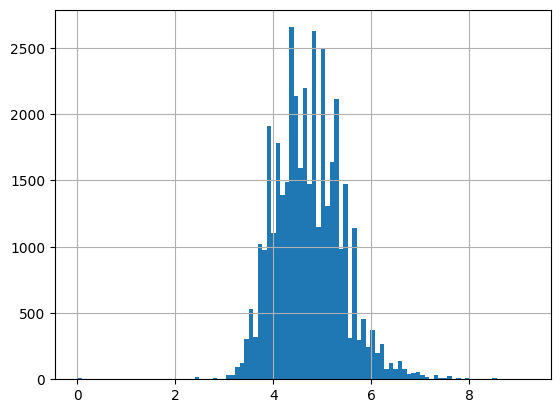

In [111]:
# target(hist) : 히스토그램으로 확인, 로그 치환한 것 확인
x_train['price'].hist(bins=100)

In [112]:
# target(describe)
x_train['price'].describe()
# 치환 하기 전 최대 10000원 까지 데이터 확인 ok

count    39116.000000
mean         4.734788
std          0.695155
min          0.000000
25%          4.248495
50%          4.663439
75%          5.170484
max          9.210440
Name: price, dtype: float64

# **3.데이터 전처리**

In [113]:
# 데이터 복사
x_train_encode = x_train.copy()
x_test_encode = x_test.copy()

In [114]:
# 범주형, 수치형 데이터 확인
display(x_train.head(2), x_test.head(2))

# 범주형 컬럼
# name 필요 없고, host_id, id는 최종적으로 삭제하자
# neighbourhood_group, neighbourhood, room_type 3개만 인코딩하자

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
34718,27528935,Private Room in Brooklyn,193502084,Linda,Brooklyn,Borough Park,40.63925,-74.00329,Private room,1,12,2019-03-23,1.16,8,0,3.713572
4046,2563611,Apartment 6,1163315,Craig,Manhattan,Harlem,40.80290,-73.95694,Private room,3,298,2019-06-27,4.67,1,42,4.653960


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
42776,33216329,1 BR Suite in Midtown Manhattan,24831061,Hosteeva,Manhattan,Midtown,40.76453,-73.98035,Private room,1,0,NaN,NaN,8,0,5.525453
30338,23453013,Studio Near Times Square,2416454,Gen,Manhattan,Hell's Kitchen,40.76000,-73.98962,Entire home/apt,3,4,2018-07-28,0.26,1,0,5.170484


In [115]:
# 범주형 데이터 one-hot encode : 성능 증진 위함
x_train_encode = pd.get_dummies(x_train_encode, columns=['neighbourhood_group', 'neighbourhood', 'room_type'])
x_test_encode = pd.get_dummies(x_test_encode, columns=['neighbourhood_group', 'neighbourhood', 'room_type'])
# 컬럼 수 다름 방지
x_train_encode, x_test_encode = x_train_encode.align(x_test_encode, join='left', axis=1)

In [116]:
# 인코딩 된 샘플 확인 (dummies)
display(x_train_encode.head(5))
# 범주형(분석한 3개 컬럼) 인코딩 확인

,id,name,host_id,host_name,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
34718,27528935,Private Room in Brooklyn,193502084,Linda,40.63925,-74.00329,1,12,2019-03-23,1.16,...,0,0,0,0,0,0,0,0,1,0
4046,2563611,Apartment 6,1163315,Craig,40.80290,-73.95694,3,298,2019-06-27,4.67,...,0,0,0,0,0,0,0,0,1,0
37841,29955544,Magnificent Loft with a Skyline view,4538731,Francois,40.73039,-73.95434,7,2,2019-04-15,0.32,...,0,0,0,0,0,0,0,1,0,0
41812,32511315,Summer Rental on Park Ave (1 Month minimum),850498,Aaron,40.78028,-73.95528,30,0,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3939,2451438,Quiet & private room in luxury doorman bldg,10193030,Kaori,40.82349,-73.94193,3,3,2017-10-03,0.05,...,0,0,0,0,0,0,0,0,1,0


In [117]:
# 필요없는 컬럼들 삭제

# 필요없는 컬럼들 삭제
x_train_encode = x_train_encode.drop('last_review', axis=1)
x_test_encode = x_test_encode.drop('last_review', axis=1)

x_train_encode = x_train_encode.drop('id', axis=1)
x_test_encode = x_test_encode.drop('id', axis=1)

x_train_encode = x_train_encode.drop('host_id', axis=1)
x_test_encode = x_test_encode.drop('host_id', axis=1)

x_train_encode = x_train_encode.drop('name', axis=1)
x_test_encode = x_test_encode.drop('name', axis=1)
# 문자열 지원 안하는 xgboost 와 인코딩 시 컬럼 수가 크게 늘까봐
x_train_encode = x_train_encode.drop('host_name', axis=1)
x_test_encode = x_test_encode.drop('host_name', axis=1)

# 샘플 확인
display(x_train_encode.head(3))

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
34718,40.63925,-74.00329,1,12,1.16,8,0,3.713572,0,1,...,0,0,0,0,0,0,0,0,1,0
4046,40.80290,-73.95694,3,298,4.67,1,42,4.653960,0,0,...,0,0,0,0,0,0,0,0,1,0
37841,40.73039,-73.95434,7,2,0.32,1,20,5.602119,0,1,...,0,0,0,0,0,0,0,1,0,0


In [118]:
# 결측치 채우기, EDA에서 'r_p_m' 확인
x_train_encode['reviews_per_month'] = x_train_encode['reviews_per_month'].fillna(0)
x_test_encode['reviews_per_month'] = x_test_encode['reviews_per_month'].fillna(0)

In [119]:
# 결측치 확인
x_train_encode.isnull().sum()
# 데이터 전처리 완료(범주형)

latitude                     0
longitude                    0
minimum_nights               0
number_of_reviews            0
reviews_per_month            0
                            ..
neighbourhood_Woodrow        0
neighbourhood_Woodside       0
room_type_Entire home/apt    0
room_type_Private room       0
room_type_Shared room        0
Length: 234, dtype: int64

In [120]:
# target 값 복사
target = x_train['price']
x_train = x_train.drop('price', axis=1)

In [121]:
# 수치형 피처 선택
# 수치형만 담을순 없나? 리스트 말고
# cols = x_train.select_dtypes(include='int64','float64') > 조금 더 생각

cols =[
      'host_id',
      'latitude',
      'longitude',
      'minimum_nights',
      'number_of_reviews',
      'reviews_per_month',
      'calculated_host_listings_count',
      'availability_365'
]

x_train = x_train[cols]
x_test = x_test[cols]

# 수치형 데이터까지 데이터 전처리 완료!

# **데이터 검증**

In [126]:
# 검증 데이터 분리
x_train_end, x_val, y_train_end, y_val = train_test_split(x_train_encode,
                                                              y_train,
                                                              test_size=0.2,
                                                              random_state=2023)

In [128]:
# xgboost
from xgboost import XGBRegressor

model = XGBRegressor(random_state=2023)
model.fit(x_train_end, y_train_end)
val_pred_log = model.predict(x_val)
pred = np.expm1(val_pred_log)

val_mse = mean_squared_error(np.expm1(y_val), pred)
print(f'Validation mse: {val_mse}')
# 1. mse,xgboost : 11387.866574614518

Validation mse: 11387.866574614518


In [129]:
# xgboost 테스트 데이터에 대한 성능 측정
from xgboost import XGBRegressor

model = XGBRegressor(random_state=2023)
model.fit(x_train_encode, y_train)
pred_log = model.predict(x_test_encode)
pred = np.expm1(pred_log)

test_mse = mean_squared_error(np.expm1(y_test), pred)
print(f'Test mse: {test_mse}')

Test mse: 7959.218979719899


In [124]:
# # 머신러닝 (회귀 LinearRegresseion)
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# model = LinearRegression()
# model.fit(x_train_encode, y_test)
# pred = model.predict(x_val)
# mean_squared_error(y_val, pred)

# # 1. mse : 54166.81336565637